# <font color = '#0091D0'><center>Reward Program<font></center>

## <font color = '#0091D0'>1. Background<font>
    

### <font color = '#0091D0'>Reward program</font>
    
Reward programs, i.e. Loyalty programs, i.e. Incentive programs, are being widely used in a spectrum of industries to promote customer loyalty and repeated consumption.  

In the case of a credit card issuer, reward programs  encourage customers’ spending actions using the card

### <font color = '#0091D0'>Client concern</font>
    
Bank Zero’s redemption costs have grown significantly over the last 2 years from 206MM to 590MM

## <font color = '#0091D0'>2. Data Preparation and preprocessing<font>

In [1]:
import pandas as pd
import numpy as np

Read 3 years of transaction data and concatenate into a master table

In [2]:
redemptionTran_2005 = pd.read_csv("CSV_Data/CSV_Data/rwrd_2005_smp_v2.csv").drop_duplicates()
redemptionTran_2006 = pd.read_csv("CSV_Data/CSV_Data/rwrd_2006_smp_v2.csv").drop_duplicates()
redemptionTran_2007 = pd.read_csv("CSV_Data/CSV_Data/rwrd_2007_smp_v2.csv").drop_duplicates()

# Concatenate 3 years of data
redemptionTran_2005['year'] = '2005'
redemptionTran_2006['year'] = '2006'
redemptionTran_2007['year'] = '2007'

frames = [redemptionTran_2005, redemptionTran_2006, redemptionTran_2007]

transaction_3years = pd.concat(frames, sort = False)


n_records_2005_dropNA = len(redemptionTran_2005.index)
n_records_2006_dropNA = len(redemptionTran_2006.index)
n_records_2007_dropNA = len(redemptionTran_2007.index)

print "Total number of unique transaction of 2005: {}".format(n_records_2005_dropNA)
print "Total number of unique transaction of 2006: {}".format(n_records_2006_dropNA)
print "Total number of unique transaction of 2007: {}".format(n_records_2007_dropNA)

Total number of unique transaction of 2005: 645417
Total number of unique transaction of 2006: 994260
Total number of unique transaction of 2007: 1045174


It is frequently used to populate missing redemption quantity with mean value

In [3]:
# impute missing redemption quantity with mean value
for i in ['2005', '2006', '2007']:
    transaction_3years.loc[transaction_3years.year == i,'QTY'] = transaction_3years[transaction_3years.year == i]['QTY'].fillna(transaction_3years[transaction_3years.year == i]['QTY'].mean())

As the dataset has business meaning, so it's very dangerous to drop all missing entities. It is found out if the award type code is "101", which is "Cash", merchant code is empty as customers would not redempt anything. In this case, we can replace the missing value with "Dummy cash"  

In [4]:
transaction_3years.loc[transaction_3years.Award_Type_Code == 'A00','Merchant_Code'] = transaction_3years.loc[transaction_3years.Award_Type_Code == 'A00','Merchant_Code'].fillna(100)

Read account level data

In [5]:
'''
Accout level data
2007 Redeemed Accounts Annual Spend/Capacity Info
'''
acct_spd_sow = pd.read_csv("CSV_Data/CSV_Data/acct_spd_sow.csv")
acct_spd_sow.dropna(inplace = True)

Read customer demographic and behavior data

In [6]:
'''
Customer Demographic and Behavior Data
2007 Redeemed Customers Demographic info
''' 
demographic = pd.read_csv("CSV_Data/CSV_Data/cm_2007_demog_v2.csv")
demographic.dropna(inplace = True)

Read account customer mapping table

In [7]:
# account customer mapping

accountCustomer = pd.read_csv("CSV_Data/CSV_Data/acct_cust_mapping.csv")
accountCustomer.dropna(inplace = True)

Merge transaction with Accounts Annual Spend/Capacity Info

In [8]:
# merge transaction with Accounts Annual Spend/Capacity Info
tran_spd_sow = transaction_3years.merge(acct_spd_sow, on = 'ACCT_REF_NB', how = 'inner')


Merge `tran_spd_sow` with account customer mapping

In [9]:
# merge master with account customer mapping
tran_spd_sow_cus = tran_spd_sow.merge(accountCustomer, on = 'ACCT_REF_NB', how = 'left')

Merge `tran_spd_sow_cus` with demographic table

In [10]:
# All information is intergrated into master table 
tran_spd_sow_cus_demo = tran_spd_sow_cus.merge(demographic, on = 'CARD_PROC_CUST_ID', how = 'inner')
tran_spd_sow_cus_demo.dropna(inplace = True)

Merchant code mapping

In [12]:
# merchant information
merchant = pd.read_csv("CSV_Data/CSV_Data/merchant_mapping.csv").drop_duplicates()

master = tran_spd_sow_cus_demo.merge(merchant, on = 'Merchant_Code', how = 'inner')

In [13]:
master['faceValue_per_tran'] = master['QTY'] * master['Face_value']
master['itemCost_per_tran'] = master['QTY'] * master['ItemCost']

In [56]:
group_year = master.groupby('year').agg({'faceValue_per_tran':sum, 'itemCost_per_tran':sum, 'QTY': sum, 'RedeemDt': 'count'}).reset_index().rename(columns = {'faceValue_per_tran':'sum_faceValue', 'itemCost_per_tran':'sum_itemCost', 'QTY':'sum_QTY', 'RedeemDt':'count_Redeem'})

group_year['CPD'] = group_year['sum_itemCost']/group_year['sum_faceValue']
group_year.sum_itemCost = (group_year.sum_itemCost/1000000).apply(lambda x: round(x, 1))

The data has been prepared and prepcocessed, the next job is to do profiling and find out solid reasons causing client concerns.

## <font color = '#0091D0'>3. Data profiling and visualization<font>

C:\Users\zhihao.fang\AppData\Local\Continuum\anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 288x288 with 0 Axes>

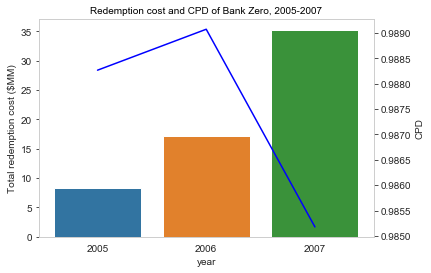

In [58]:
visualizationimport matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


plt.figure(figsize=(4,4))
fig = plt.figure()

plt.ticklabel_format(style = 'plain') # in case of scientific notation
ax1 = fig.add_subplot(111)
ax1 = sns.barplot(x="year", y="sum_itemCost", data = group_year,ci=0)

ax1.set_title('Redemption cost and CPD of Bank Zero, 2005-2007',fontsize=10,color='black')

plt.ylabel('Total redemption cost ($MM)')
ax2 = ax1.twinx()
x = group_year['year']
y1 = group_year['CPD']
ax2.plot(x, y1, 'b')
ax1.grid(False)
ax2.grid(False)
ax2.set_ylabel('CPD',fontsize='10')
plt.show()

#### <font color = '#0091D0'>Conclusion 1 : The CPD of each year is higher than 0.9, which is overall CPD in US credit card industry.  And the redemption cost was increasing rapidly over 3years</font>


Look at the proportion of Major Merchants in all Gift Partners. It should be noticed that "cash" merchant is not consider here as it is not real merchant

In [17]:
sample_nocash = master[master.Merchant != 'Cash']
group_merchant = sample_nocash.groupby('Merchant').agg({'faceValue_per_tran':sum, 'itemCost_per_tran':sum, 'QTY': sum, 'RedeemDt': 'count'}).reset_index().rename(columns = {'faceValue_per_tran':'sum_faceValue', 'itemCost_per_tran':'sum_itemCost', 'QTY':'sum_QTY', 'RedeemDt':'count_Redeem'})

group_merchant.sort_values(by = ['sum_itemCost'], ascending = [False], inplace = True)
group_merchant['Percent (%)'] = (group_merchant['sum_itemCost'] / sum(group_merchant['sum_itemCost']) * 100).apply(lambda x: round(x,0))

top1 = group_merchant['Percent (%)'].iloc[0]
top2 = group_merchant['Percent (%)'].iloc[1]
top3 = group_merchant['Percent (%)'].iloc[2]
top4 = group_merchant['Percent (%)'].iloc[3]
others = 100 - (top1+top2+top3+top4)


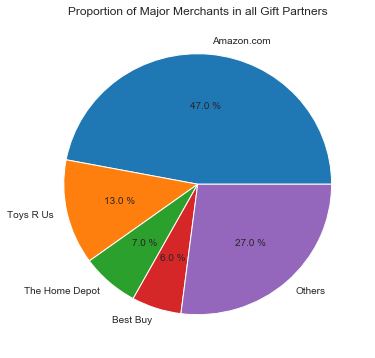

In [19]:
name_list = [group_merchant['Merchant'].iloc[0], group_merchant['Merchant'].iloc[1], group_merchant['Merchant'].iloc[2], group_merchant['Merchant'].iloc[3], 'Others']
num_list =[top1, top2, top3, top4, others]

plt.figure(figsize=(6,6))
plt.title('Proportion of Major Merchants in all Gift Partners')

plt.pie(x=num_list, labels=name_list, autopct='%3.1f %%')
plt.show()

#### <font color = '#0091D0'>Conclusion 2 : Amazon and Toys Occupy the Greatest Proportion in Merchant Cost</font>


In [20]:
group_year_merchant = master.groupby(['year','Merchant']).agg({'faceValue_per_tran':sum, 'itemCost_per_tran':sum, 'QTY': sum, 'RedeemDt': 'count'}).reset_index().rename(columns = {'faceValue_per_tran':'sum_faceValue', 'itemCost_per_tran':'sum_itemCost', 'QTY':'sum_QTY', 'RedeemDt':'count_Redeem'})

group_year_merchant['CPD'] = group_year_merchant['sum_itemCost']/group_year_merchant['sum_faceValue']

group_year_merchant = group_year_merchant[group_year_merchant.Merchant.isin(['Amazon.com', 'Toys R Us'])]

Text(0.5,1,'CPD per year')

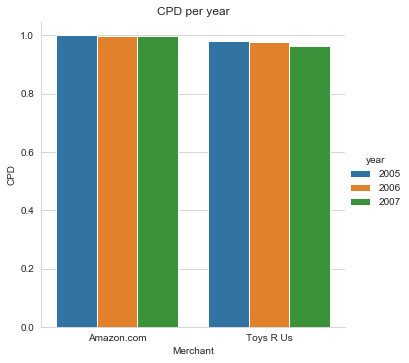

In [55]:
g = sns.catplot(x='Merchant', y='CPD', hue='year', data=group_year_merchant, kind='bar')
plt.title('CPD per year')

#### <font color = '#0091D0'>Conclusion 3: CPD of Amazon and Toys 'R' Us Are Too High, they are larger than the negotiable range [0.8, 0.85]. That is to say, we should focus on negotiate with Amazon and Toys 'R' Us</font>

In [23]:
# award type mapping 

awardMapping = {"A00":"Checks", "A01": "Gift Cards", "A10":"Gift Certificates", "A11":"Others"}

master = master.replace({"Award_Type_Code": awardMapping})

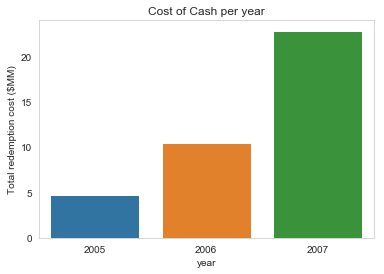

In [53]:
group_award_year = master.groupby(['Award_Type_Code','year']).agg({'faceValue_per_tran':sum, 'itemCost_per_tran':sum, 'QTY': sum, 'RedeemDt': 'count'}).reset_index().rename(columns = {'faceValue_per_tran':'sum_faceValue', 'itemCost_per_tran':'sum_itemCost', 'QTY':'sum_QTY', 'RedeemDt':'count_Redeem'})

group_award_year.sort_values(by = ['sum_itemCost'], ascending = [False], inplace = True)
group_award_year['Percent (%)'] = (group_award_year['sum_itemCost'] / sum(group_award_year['sum_itemCost']) * 100).apply(lambda x: round(x,0))
group_award_year_cash = group_award_year[group_award_year.Award_Type_Code == 'Checks']

group_award_year_cash.sum_itemCost = (group_award_year_cash.sum_itemCost/1000000).apply(lambda x: round(x, 1))

g = sns.barplot(x='year', y='sum_itemCost', data=group_award_year_cash)
plt.title('Cost of Cash per year')
plt.ylabel('Total redemption cost ($MM)')
g.grid(False)

#### <font color = '#0091D0'>Conclusion 4 : Cost of cash was increasing rapidly over 3 years</font>

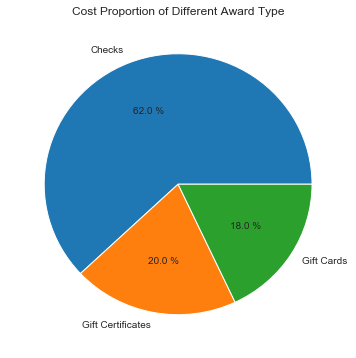

In [31]:
group_award = master.groupby(['Award_Type_Code']).agg({'faceValue_per_tran':sum, 'itemCost_per_tran':sum, 'QTY': sum, 'RedeemDt': 'count'}).reset_index().rename(columns = {'faceValue_per_tran':'sum_faceValue', 'itemCost_per_tran':'sum_itemCost', 'QTY':'sum_QTY', 'RedeemDt':'count_Redeem'})

group_award.sort_values(by = ['sum_itemCost'], ascending = [False], inplace = True)
group_award['Percent (%)'] = (group_award['sum_itemCost'] / sum(group_award['sum_itemCost']) * 100).apply(lambda x: round(x,0))
group_award

name_list = list(group_award['Award_Type_Code'])
num_list =list(group_award['Percent (%)'])

plt.figure(figsize=(6,6))
plt.title('Cost Proportion of Different Award Type')

plt.pie(x=num_list, labels=name_list, autopct='%3.1f %%')
plt.show()

#### <font color = '#0091D0'>Conclusion 5 : By looking at the cost vs award type, it is found out that customer are more likely to redempt cash instead of gifts, which leads to high CPD</font>